# Build an interface between deepXDE and Altair Simulation

In [1]:
# from google.colab import drive
# drive.mount('/content/Drive')

# import os
# os.chdir(os.path.expanduser("~"))
# os.chdir("/content")
# os.chdir("Drive/MyDrive/College (freshman - senior)/DS UROP/Physics ML/pinnDSE")
# !ls

# import sys
# if 'Drive/MyDrive/College (freshman - senior)/DS UROP/Physics ML/pinnDSE' not in sys.path:
#   sys.path.append('Drive/MyDrive/College (freshman - senior)/DS UROP/Physics ML/pinnDSE')

# n_points = 100
# theta = np.linspace(-4 * np.pi, 4 * np.pi, n_points)
# z = np.linspace(-2, 2, n_points)
# r = z ** 2 + 1
# x = r * np.sin(theta)
# y = r * np.cos(theta)
# points = np.column_stack((x, y, z))

# # Create spline with 1000 interpolation points
# spline = pv.Spline(points, 1000)

# # add scalars to spline and plot it
# spline["scalars"] = np.arange(spline.n_points)
# tube = spline.tube(radius=0.1)
# tube.plot(smooth_shading=True, notebook=True)


# # setup enviornment for interactive plotting
# !apt-get install -qq xvfb
# !pip install pyvista panel -q
# os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
# os.environ['DISPLAY'] = ':99'

# import panel as pn
# pn.extension('vtk')

In [2]:
import numpy as np
import pandas as pd
import pyvista as pv
import deepxde as dde
import pickle


from pinnDSE.geom import MeshGeom
from pinnDSE.viz import *
from pinnDSE.elasticity import *
from pinnDSE.bc import *

# --UNITS--
# displacement: mm
# stress: MPa
# force: N
# E = 2e5 MPa (AISI Carbon Steel)
# nu = 0.27
# rho = 7.85e-3 
# yield = 490 MPa

Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


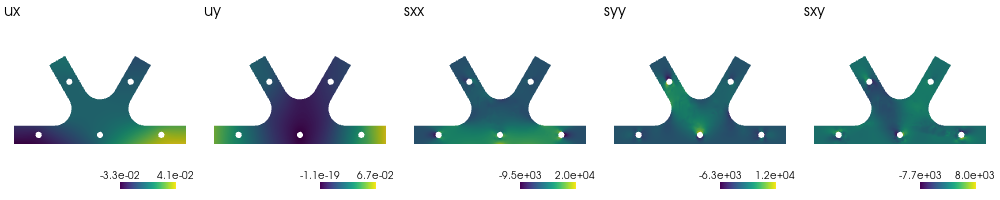

In [6]:
# load using the alternative format

meshFile = 'data/connector/v1.0/connectorDesign03.vtk'
pickleFile = 'data/connector/v1.0/connectorDesign03.p'
geom = MeshGeom(meshFile=meshFile, pickleFile=pickleFile)

plotScalarFields(geom.mesh, geom.resDf)

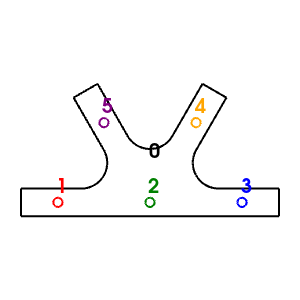

In [7]:
drawBoundaries(geom.bndDict)

Compiling model...
Building feed-forward neural network...
'build' took 0.086735 s

'compile' took 2.110429 s

Initializing variables...
Training model...

Step      Train loss                                                                                                                                                                    Test loss                                                                                                                                                                     Test metric
0         [1.65e+04, 4.95e+05, 1.34e+04, 1.74e+05, 2.71e+03, 5.95e-09, 6.97e-08, 7.06e+03, 8.41e+04, 1.48e+04, 1.48e+05, 5.76e+03, 3.14e+04, 8.46e+03, 9.28e+04, 8.24e+01, 1.02e+03]    [1.66e+04, 4.97e+05, 1.08e+04, 1.42e+05, 2.30e+03, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00]    []  

Best model at step 0:
  train loss: 1.09e+06
  test loss: 6.69e+05
  test metric: []

'train' took 1.220582 s


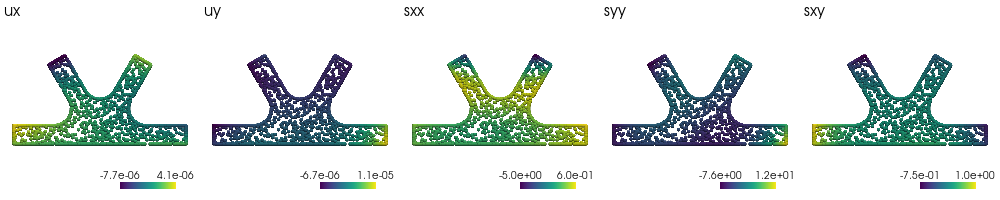

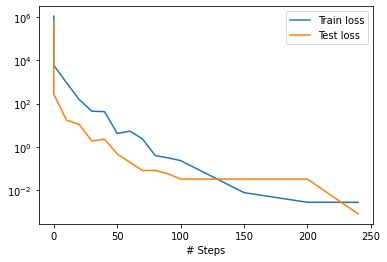

In [17]:
# supports
xSup = SupportBC(geom, bndId=2, U=0, component=0)
ySup = SupportBC(geom, bndId=2, U=0, component=1)

# free edges
xTr0 = TractionBC(geom, bndId=0, T=0, component=0)
yTr0 = TractionBC(geom, bndId=0, T=0, component=1)

# loaded edges
xTr1 = TractionBC(geom, bndId=1, T=-1.0/geom.bndAreaDict[1], component=0)
yTr1 = TractionBC(geom, bndId=1, T=0, component=1)

xTr5 = TractionBC(geom, bndId=5, T=(-3/(4*np.sqrt(3)))/geom.bndAreaDict[5], component=0)
yTr5 = TractionBC(geom, bndId=5, T=(3/4)/geom.bndAreaDict[5], component=1)

xTr4 = TractionBC(geom, bndId=4, T=(1/(4*np.sqrt(3)))/geom.bndAreaDict[4], component=0)
yTr4 = TractionBC(geom, bndId=4, T=(1/4)/geom.bndAreaDict[4], component=1)

xTr3 = TractionBC(geom, bndId=3, T=(1 + 1/(2*np.sqrt(3)))/geom.bndAreaDict[3], component=0)
yTr3 = TractionBC(geom, bndId=3, T=0, component=1)

# problem setup
bndNumSamplesDir = {0: 800, 1: 200, 2: 200, 3: 200, 4: 200, 5: 200}
# bndNumSamplesDir = {bndId:int(l*100) for bndId,l in geom.bndLensDict.items()}
paramDict = {'E':2e5, 'nu':0.3}
bcList = [xSup,ySup, xTr0,yTr0,xTr1,yTr1,xTr3,yTr3,xTr4,yTr4,xTr5,yTr5]
data = StrctPDE(geom, 
            elasticityEqs, 
            bcList, 
            num_domain=500, 
            num_boundary_dir=bndNumSamplesDir, 
            num_test=500,
            paramDict=paramDict)

for bc in bcList:
    if isinstance(bc, TractionBC): 
        bc.train_n = data.train_n

# build model
net = dde.maps.FNN([2] + [256]*4  + [5], "tanh", "Glorot uniform")
outScales = np.array([1e-2, 1e-2, 1e4, 1e4, 1e3]) # [ux,uy,sxx,syy,sxy]
net.apply_output_transform(lambda x,y : y*outScales) 
model = dde.Model(data, net)

# get the unweighted loss values
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=0)
lw = losshistory.loss_train[0]**(-1)

# train
model.compile("adam", lr=0.0001, loss_weights=lw)
losshistory, train_state = model.train(epochs=100, display_every=10)

model.compile("L-BFGS-B", loss_weights=lw)
model.train_op.optimizer_kwargs['options']['maxiter']=3000
model.train_op.optimizer_kwargs['options']['maxfun']=3000
losshistory, train_state = model.train(display_every=50)

dde.postprocessing.plot_loss_history(losshistory)

# test
pred = model.predict(data.train_x)
predDf = pd.DataFrame(pred, columns=['ux', 'uy', 'sxx', 'syy', 'sxy'])
pc = pv.PolyData(addZ(data.train_x))
plotScalarFields(pc, predDf)

ux        0.012738
uy        0.024757
sxx    4718.742188
syy    2236.505859
sxy    1562.929443
dtype: float32


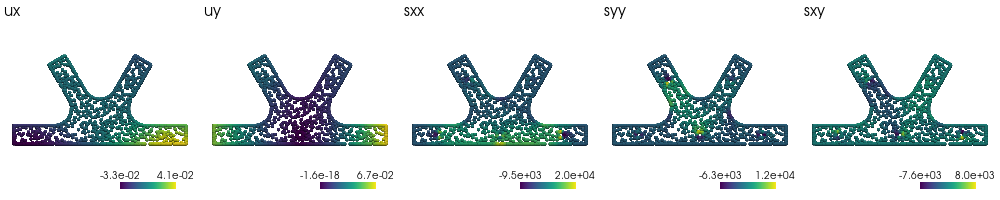

In [10]:
intResDf = geom.sampleRes(data.train_x)
MAE = (predDf-intResDf.drop(columns='vonMises')).abs().mean()
print(MAE)
plotScalarFields(pc, intResDf)

In [12]:
MAE = (predDf-intResDf.drop(columns='vonMises')).abs().mean()
print(MAE)

ux        0.012713
uy        0.024761
sxx    4718.266602
syy    2236.355713
sxy    1563.057983
dtype: float32


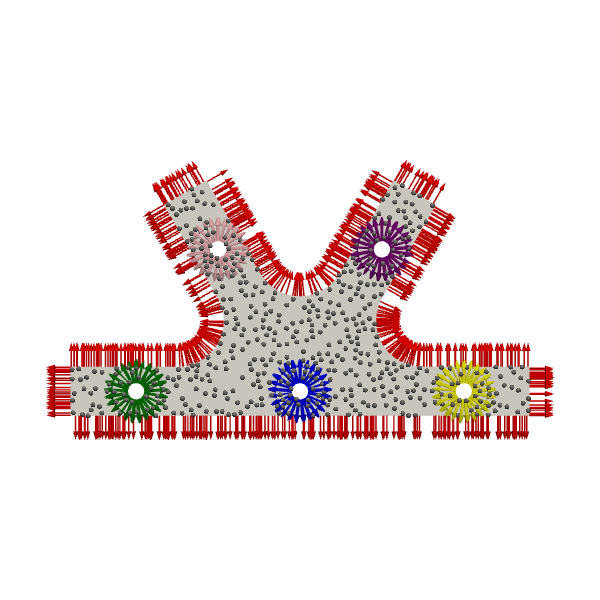

In [13]:
plotter = pv.Plotter(border=False)
plotter.set_background('white')
plotter.add_mesh(geom.mesh, show_edges=False)

# domain samples
pc = pv.PolyData(addZ(data.domainSamples))
plotter.add_mesh(pc, render_points_as_spheres=True, color='gray')


# boundary samples
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'pink']
for bndId, color in zip(geom.bndDict.keys(), colors):
    samples = addZ(data.bndSampleDict[bndId])
    normals = addZ(data.bndNormalsDict[bndId])
    plotter.add_arrows(samples, normals, 0.1, color=color)
plotter.show(window_size=(600,600), cpos='xy');